In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-11 10:09:41.389205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752253781.403121 1954027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752253781.407407 1954027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752253781.420085 1954027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752253781.420097 1954027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752253781.420098 1954027 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
this is not correct overwritting indecis 
x_train_3d = np.zeros((5000,64,64,64))
for i in range (int(len(x_train_3d)/5)):
    for j in range (5):     
        x_train_3d[i*(j+1)] =  stochastic_density(ref_d,10000*(j+1))
print("train generated")

train generated


In [5]:

x_val_3d = np.zeros((1000,64,64,64))
for i in range (int(len(x_val_3d)/5)):
    for j in range (5):     
        x_val_3d[i*(j+1)] =  stochastic_density(ref_d,10000*(j+1))
print("val generated")

val generated


In [6]:

x_test_3d = np.zeros((500,64,64,64))
for i in range (int(len(x_test_3d)/5)):
    x_test_3d[i] =  stochastic_density(ref_d,10000*5)
print("test generated")


test generated


In [7]:
y_test_3d = np.zeros((x_test_3d.shape[0],64,64,64))
y_train_3d = np.zeros((x_train_3d.shape[0],64,64,64))
y_val_3d = np.zeros((x_val_3d.shape[0],64,64,64))

for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
print("y generated")

y generated


In [8]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            buffer_scale=1.10):
    """
    Projects all input and output 3D densities to 2D RGB with shared normalization.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        buffer_scale: float, buffer for normalization (default 10%)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    # Convert all to RGB (unnormalized)
    x_train_rgb = split_sum_rgb(x_train_3d)
    x_val_rgb   = split_sum_rgb(x_val_3d)
    x_test_rgb  = split_sum_rgb(x_test_3d)
    y_train_rgb = split_sum_rgb(y_train_3d)
    y_val_rgb   = split_sum_rgb(y_val_3d)
    y_test_rgb  = split_sum_rgb(y_test_3d)

    # Compute global max
    global_max = np.max([
        x_train_rgb.max(), x_val_rgb.max(), x_test_rgb.max(),
        y_train_rgb.max(), y_val_rgb.max(), y_test_rgb.max()
    ])
    buffered_max = global_max * buffer_scale

    # Normalize all
    def normalize(x_rgb):
        return np.clip(x_rgb / buffered_max, 0, 1)

    return (
        normalize(x_train_rgb), normalize(x_val_rgb), normalize(x_test_rgb),
        normalize(y_train_rgb), normalize(y_val_rgb), normalize(y_test_rgb)
    )


In [10]:
x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb = batch_project_3d_to_rgb(
    x_train_3d, x_val_3d, x_test_3d,
    y_train_3d, y_val_3d, y_test_3d,
    buffer_scale=1.10
)




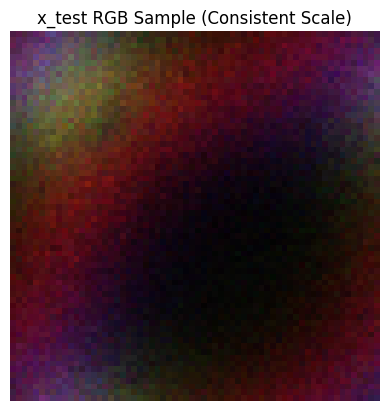

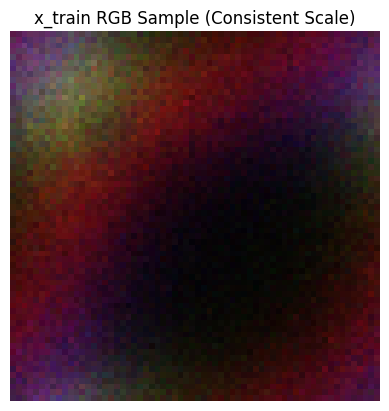

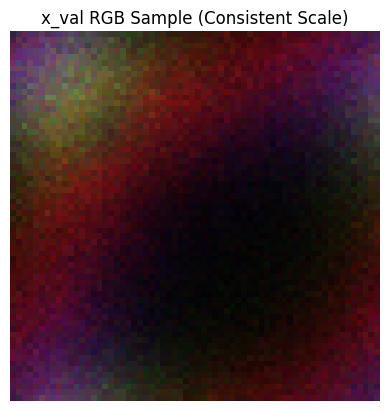

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_test_rgb[0])
plt.title("x_test RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_train_rgb[0])
plt.title("x_train RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_val_rgb[0])
plt.title("x_val RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 565.1525 - val_loss: 564.4744
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.4503 - val_loss: 564.4514
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.4506 - val_loss: 564.4365
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.4351 - val_loss: 564.4160
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.4163 - val_loss: 564.3829
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.3615 - val_loss: 564.3159
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 564.2960 - val_loss: 564.1828
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 564.1404 - val_loss: 563.9941
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 563.9581 - val_loss: 563.8854
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 563.8770 - val_loss: 563.8583
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 563.8560 - val_l

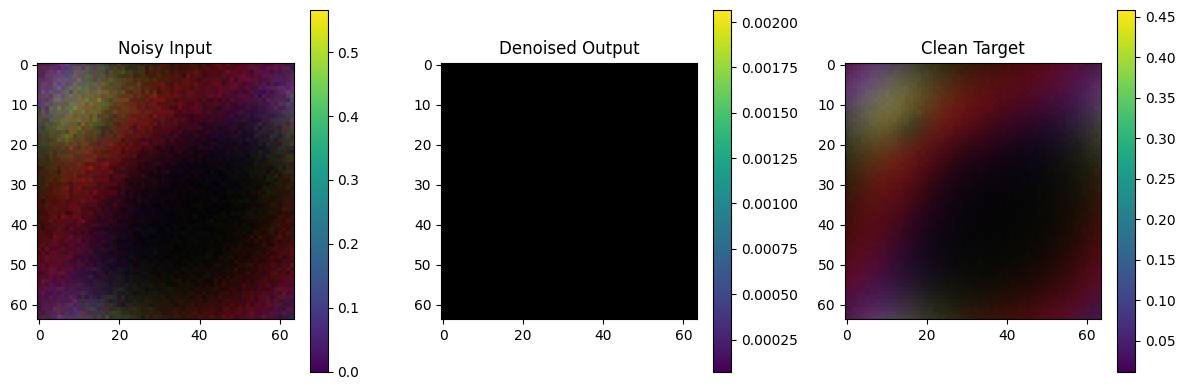

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable

# --- Custom Renormalization Layer ---
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=1, keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# --- Custom JS Divergence Loss ---
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# --- Feed-Forward DAE Model ---
def create_ffnn_dae(input_dim):
    return tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid'),
        Renormalize(target_sum=8.0)
    ])

# --- Main Execution ---
if __name__ == '__main__':
    # Assumes these are already defined: x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb
    # Shape: (N, 64, 64, 3)

    H, W, C = x_train_rgb.shape[1:]
    input_dim = H * W * C

    # Flatten all inputs/targets
    x_train_flat = x_train_rgb.reshape((-1, input_dim)).astype(np.float32)
    y_train_flat = y_train_rgb.reshape((-1, input_dim)).astype(np.float32)
    x_val_flat   = x_val_rgb.reshape((-1, input_dim)).astype(np.float32)
    y_val_flat   = y_val_rgb.reshape((-1, input_dim)).astype(np.float32)
    x_test_flat  = x_test_rgb.reshape((-1, input_dim)).astype(np.float32)
    y_test_flat  = y_test_rgb.reshape((-1, input_dim)).astype(np.float32)

    # Build and compile model
    dae = create_ffnn_dae(input_dim)
    dae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=jensen_shannon_divergence_loss)

    # Early stopping
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train
    dae.fit(x_train_flat, y_train_flat,
            validation_data=(x_val_flat, y_val_flat),
            epochs=100,
            batch_size=50,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Plot Example ---
    i = 0
    denoised_flat = dae.predict(x_test_flat[i:i+1])[0]
    denoised = denoised_flat.reshape((H, W, C))
    noisy_input = x_test_rgb[i]
    true_clean = y_test_rgb[i]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input)
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean)
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.1373 - val_loss: 0.1371
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1371 - val_loss: 0.1371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Tot

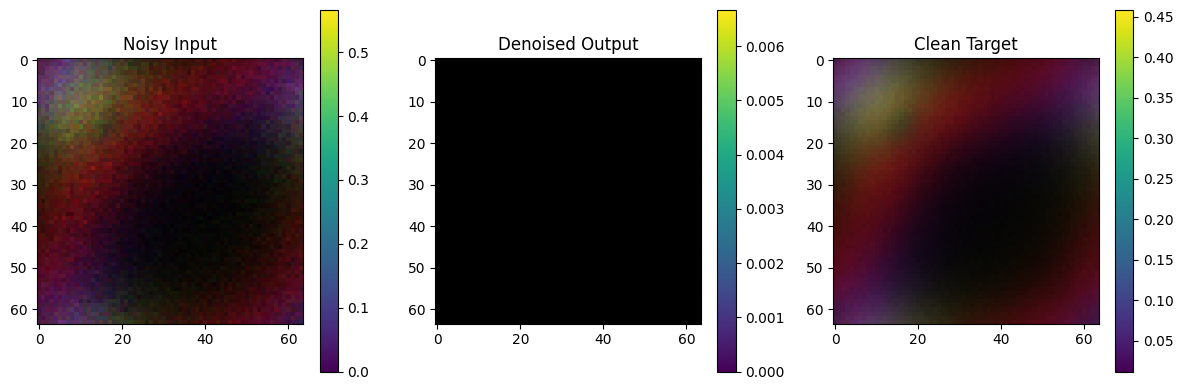

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# --- Create CAE for RGB data ---
def create_rgb_dae(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Use softplus for smooth positive outputs (better gradients than relu)
    x = layers.Conv2D(3, (3, 3), activation='softplus', padding='same')(x)

    return models.Model(inputs, x)


# --- Main ---
if __name__ == '__main__':
    input_shape = (64, 64, 3)  # Use RGB input

    cae = create_cae(input_shape)
    cae.compile(optimizer='adam', loss='mae')

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Make sure inputs are float32
    x_train_rgb = x_train_rgb.astype(np.float32)
    y_train_rgb = y_train_rgb.astype(np.float32)
    x_val_rgb = x_val_rgb.astype(np.float32)
    y_val_rgb = y_val_rgb.astype(np.float32)
    x_test_rgb = x_test_rgb.astype(np.float32)
    y_test_rgb = y_test_rgb.astype(np.float32)

    cae.fit(x_train_rgb, y_train_rgb,
            validation_data=(x_val_rgb, y_val_rgb),
            epochs=50,
            batch_size=20,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and plot ---
    i = 0
    denoised = cae.predict(x_test_rgb[i:i+1])[0]  # Shape (64, 64, 3)

    # --- Check total electrons ---
    total_electrons = np.sum(denoised)
    print("Total number of electrons (should ≈ 8):", total_electrons)

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test_rgb[i])
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(y_test_rgb[i])
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [17]:
print("Target stats:")
print("min:", np.min(y_train_rgb))
print("max:", np.max(y_train_rgb))
print("mean:", np.mean(y_train_rgb))
print("sum per image:", np.sum(y_train_rgb, axis=(1,2,3)).mean())


Target stats:
min: 0.0076139118
max: 0.48341122
mean: 0.137717
sum per image: 1692.262


Global max for normalization: 1.0
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - loss: 0.1386 - val_loss: 0.0074
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - loss: 0.0039 - val_loss: 0.0066
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 0.0025 - val_loss: 0.0025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


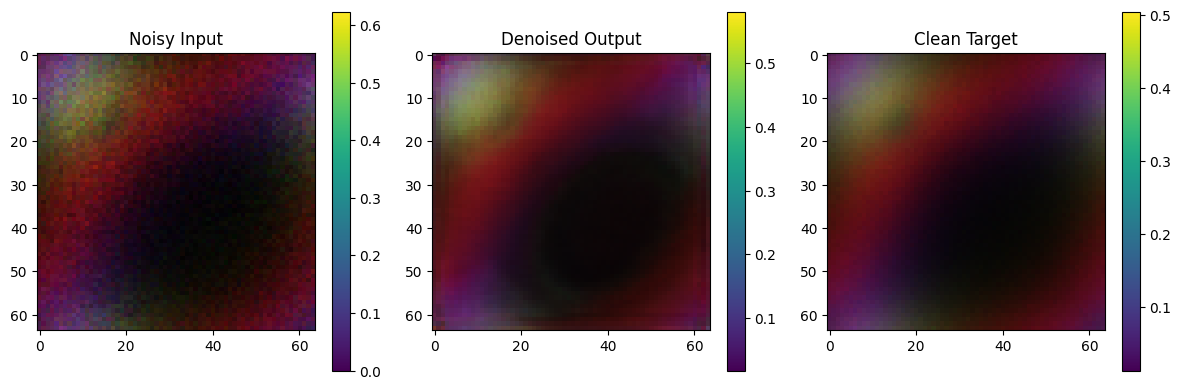

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# --------------------------
# STEP 1: Normalize All Data Together
# --------------------------

# Combine all datasets to normalize with global max
combined = np.concatenate([
    x_train_rgb, y_train_rgb,
    x_val_rgb, y_val_rgb,
    x_test_rgb, y_test_rgb
], axis=0)

global_max = np.max(combined)
print("Global max for normalization:", global_max)

# Normalize
x_train_rgb = x_train_rgb / global_max
y_train_rgb = y_train_rgb / global_max
x_val_rgb = x_val_rgb / global_max
y_val_rgb = y_val_rgb / global_max
x_test_rgb = x_test_rgb / global_max
y_test_rgb = y_test_rgb / global_max

# --------------------------
# STEP 2: Create Model
# --------------------------

def create_rgb_dae(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Output layer: softplus keeps values positive and smooth
    outputs = layers.Conv2D(3, (3, 3), activation='softplus', padding='same')(x)

    return models.Model(inputs, outputs)

# --------------------------
# STEP 3: Train Model
# --------------------------

model = create_rgb_dae(input_shape=(64, 64, 3))
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())  # or 'mae'

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x_train_rgb, y_train_rgb,
          validation_data=(x_val_rgb, y_val_rgb),
          epochs=5,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)

# --------------------------
# STEP 4: Predict & Visualize
# --------------------------

i = 0  # test index
denoised = model.predict(x_test_rgb[i:i+1])[0] * global_max  # de-normalize
noisy_input = x_test_rgb[i] * global_max
clean_target = y_test_rgb[i] * global_max

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_input)
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(denoised)
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(clean_target)
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


In [21]:
def create_rgb_unet(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(bn)
    concat1 = layers.Concatenate()([u1, c2])
    d1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    u2 = layers.UpSampling2D((2, 2))(d1)
    concat2 = layers.Concatenate()([u2, c1])
    d2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d2)

    return models.Model(inputs, outputs)
model = create_rgb_unet((64, 64, 3))
model.compile(optimizer='adam', loss='mae')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x_train_rgb, y_train_rgb,
          validation_data=(x_val_rgb, y_val_rgb),
          epochs=5,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - loss: 0.1480 - val_loss: 0.0372
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - loss: 0.0375 - val_loss: 0.0316
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - loss: 0.0308 - val_loss: 0.0274
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - loss: 0.0250 - val_loss: 0.0261


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


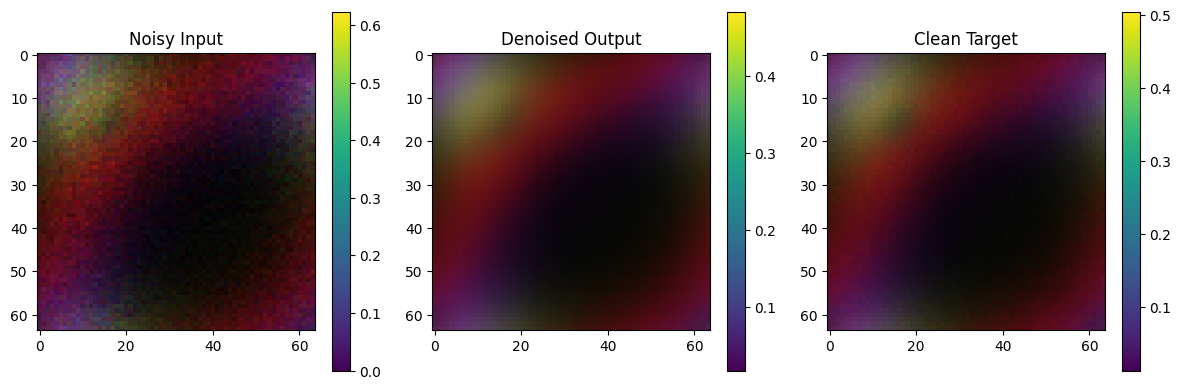

In [22]:
i = 0  # test index
denoised = model.predict(x_test_rgb[i:i+1])[0] * global_max  # de-normalize
noisy_input = x_test_rgb[i] * global_max
clean_target = y_test_rgb[i] * global_max

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_input)
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(denoised)
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(clean_target)
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


In [24]:
def project_3d_density_to_rgb(x_3d, buffer_scale=1.10):
    N, H, W, D = x_3d.shape
    thirds = np.array_split(np.arange(D), 3)

    r_channel = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
    g_channel = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
    b_channel = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)

    x_rgb = np.stack([r_channel, g_channel, b_channel], axis=-1)

    # Global normalization is not applied here — assume it was done externally
    return x_rgb


In [27]:
import numpy as np
import h5py
from scipy.spatial.distance import jensenshannon

# === Helper: Normalize for JSD ===
def normalize_for_jsd(img):
    flat = img.astype(np.float64).flatten()
    flat = np.clip(flat, 1e-12, None)
    return flat / np.sum(flat)

# === Load reference ===
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]  # shape: (64, 64, 64)

ref_d = np.expand_dims(ref_d, axis=0)  # shape: (1, 64, 64, 64)
ref_rgb = project_3d_density_to_rgb(ref_d)[0]  # shape: (64, 64, 3)
ref_rgb = ref_rgb / (np.max(ref_rgb) * 1.10)  # match training-time buffer
ref_rgb = np.clip(ref_rgb, 0, 1)

# === Get test image and prediction ===
i = 0
noisy_rgb = x_test_rgb[i]
denoised_rgb = model.predict(x_test_rgb[i:i+1])[0]

# === Also encode x_test_3d[i] to RGB ===
test_density_rgb = project_3d_density_to_rgb(np.expand_dims(x_test_3d[i], axis=0))[0]
test_density_rgb = test_density_rgb / (np.max(test_density_rgb) * 1.10)
test_density_rgb = np.clip(test_density_rgb, 0, 1)

# === Compute JSDs ===
p_ref = normalize_for_jsd(ref_rgb)
p_noisy = normalize_for_jsd(noisy_rgb)
p_denoised = normalize_for_jsd(denoised_rgb)
p_test_density = normalize_for_jsd(test_density_rgb)

jsd_noisy = jensenshannon(p_ref, p_noisy, base=2)**2
jsd_denoised = jensenshannon(p_ref, p_denoised, base=2)**2
jsd_rawdensity = jensenshannon(p_ref, p_test_density, base=2)**2

# === Print ===
print(f"JSD (Noisy RGB vs Ref RGB):      {jsd_noisy:.6f}")
print(f"JSD (Denoised RGB vs Ref RGB):   {jsd_denoised:.6f}")
print(f"JSD (Test 3D Density RGB vs Ref): {jsd_rawdensity:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
JSD (Noisy RGB vs Ref RGB):      0.005606
JSD (Denoised RGB vs Ref RGB):   0.000114
JSD (Test 3D Density RGB vs Ref): 0.005606
